# 重回帰分析

### データの読み込み

『家計調査』2017年11月、第2−6表「年間収入階級別1世帯当たり1か月間の収入と支出」から作成した所得階級と支出のデータ`kakei201709_l18.csv`を用いる.

月間消費支出(円)(`CONS`), 月間消費支出(1万円)(`CONS1`),
年間収入(1万円)(INC), 有業人員(人)(`WORK`). いずれも調査世帯の平均値

In [ ]:
library(pacman)
p_load(here)
kakei <- readr::read_csv(here("data", "kakei201709_l18.csv"))

Rows: 18 Columns: 4
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
dbl (4): CONS, CONS1, INC, WORK

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.

### ペアプロット

いくつかの変数をまとめて散布図を描くには,
`GGally`パッケージの`ggpairs()`関数が便利.
右上(upper)にはピアソンの積率相関係数を示し,
対角線(diag)には密度などを表してくれる.

Installing package into '/cloud/lib/x86_64-pc-linux-gnu-library/4.4'
(as 'lib' is unspecified)

also installing the dependencies 'patchwork', 'ggstats', 'plyr'


GGally installed

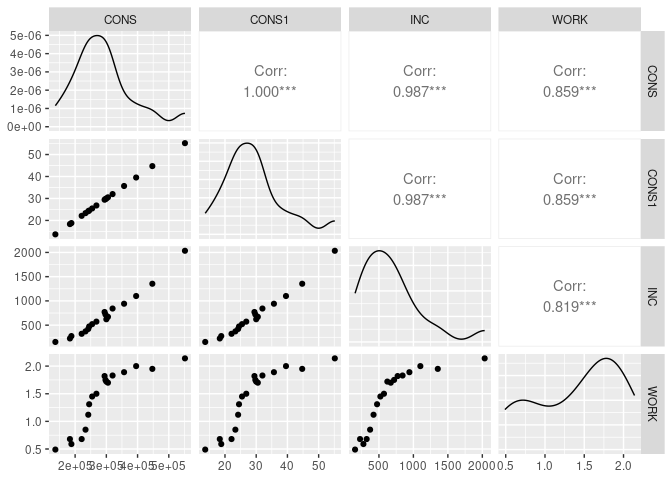

In [ ]:
p_load(GGally)

### 最尤推定

最尤推定法を利用するには, `glm()`関数を利用する.
確率密度関数の分布族として正規分布(ガウス分布)を利用することを`family = "gaussian"`で宣言する.
説明変数を増やして重回帰分析とするには, 説明変数を`+`でつなぐ.
最小二乗法を行う`lm()`関数でも同じ.

In [ ]:
model1 <- glm(CONS1 ~ INC, 
              family = "gaussian",
              data   = kakei)
model2 <- glm(CONS1 ~ INC + WORK, 
              family = "gaussian",
              data   = kakei)
model3 <- glm(CONS1 ~ WORK, 
              family = "gaussian", 
              data   = kakei)

### 結果の表示

`jtools`パッケージの`summ()`関数を利用して結果を確認する.
最尤推定法は正規分布以外も利用できるため,
より汎用的な$R^2$などが計算されるが, 今回は線形回帰分析であるため割愛.
最終行に$\hat{\sigma}^2$も計算される.

In [ ]:
p_load(jtools)
summ(model2)

MODEL INFO:
Observations: 18
Dependent Variable: CONS1
Type: Linear regression 

MODEL FIT:
χ²(2) = 1661.80, p = 0.00
Pseudo-R² (Cragg-Uhler) = 0.98
Pseudo-R² (McFadden) = 0.54
AIC = 69.39, BIC = 72.95 

Standard errors:MLE
------------------------------------------------
                     Est.   S.E.   t val.      p
----------------- ------- ------ -------- ------
(Intercept)         12.24   1.05    11.60   0.00
INC                  0.02   0.00    13.92   0.00
WORK                 2.83   1.13     2.50   0.02
------------------------------------------------

Estimated dispersion parameter = 2.13 

### 標準回帰係数の算出

標準回帰係数を算出するには,
`scale = TRUE, transform.response = TRUE`を利用する.

In [ ]:
summ(model2, 
     scale              = TRUE, 
     transform.response = TRUE)

MODEL INFO:
Observations: 18
Dependent Variable: CONS1
Type: Linear regression 

MODEL FIT:
χ²(2) = 16.68, p = 0.00
Pseudo-R² (Cragg-Uhler) = 1.05
Pseudo-R² (McFadden) = 1.43
AIC = -13.44, BIC = -9.88 

Standard errors:MLE
------------------------------------------------
                     Est.   S.E.   t val.      p
----------------- ------- ------ -------- ------
(Intercept)         -0.00   0.03    -0.00   1.00
INC                  0.86   0.06    13.92   0.00
WORK                 0.15   0.06     2.50   0.02
------------------------------------------------

Estimated dispersion parameter = 0.02 

Continuous variables are mean-centered and scaled by 1 s.d.

### 複数の分析結果を並べる

複数の分析結果を並べるのには`stargazer`は有用.

In [ ]:
p_load(stargazer)
stargazer(model1, model2, model3,
          type              = "text",
          style             = "all", 
          ci                = TRUE,
          star.cutoffs      = NA, 
          omit.table.layout = 'n',
          align             = TRUE)


                                        Dependent variable:                
                        ---------------------------------------------------
                                               CONS1                       
                              (1)              (2)               (3)       
---------------------------------------------------------------------------
INC                          0.021            0.019                        
                         (0.020, 0.023)   (0.016, 0.021)                   
                           t = 24.168       t = 13.918                     
                           p = 0.000        p = 0.000                      
WORK                                          2.826            15.739      
                                          (0.607, 5.046)  (11.143, 20.336) 
                                            t = 2.496         t = 6.711    
                                            p = 0.025        p = 0.00001   
Constant   

### AICによるモデル間の比較

`AIC()`関数を用いて、モデル推定結果を比較できる.

In [ ]:
AIC(model1, model2, model3)

       df       AIC
model1  3  73.63766
model2  4  69.38577
model3  3 114.77849

### BICによるモデル間の比較

`BIC()`関数を用いて、モデル推定結果を比較できる.

In [ ]:
BIC(model1, model2, model3)

       df       BIC
model1  3  76.30878
model2  4  72.94725
model3  3 117.44960

## 結果の図示

### 結果の図示

回帰分析の結果は表だけでなく, グラフ化するとわかりやすい.
結果のグラフ化には`coefplot`パッケージの`coefplot()`関数が便利.

Installing package into '/cloud/lib/x86_64-pc-linux-gnu-library/4.4'
(as 'lib' is unspecified)

also installing the dependencies 'sys', 'askpass', 'curl', 'openssl', 'later', 'assertthat', 'htmlwidgets', 'xts', 'httr', 'lazyeval', 'crosstalk', 'data.table', 'promises', 'reshape2', 'useful', 'dygraphs', 'plotly'


coefplot installed

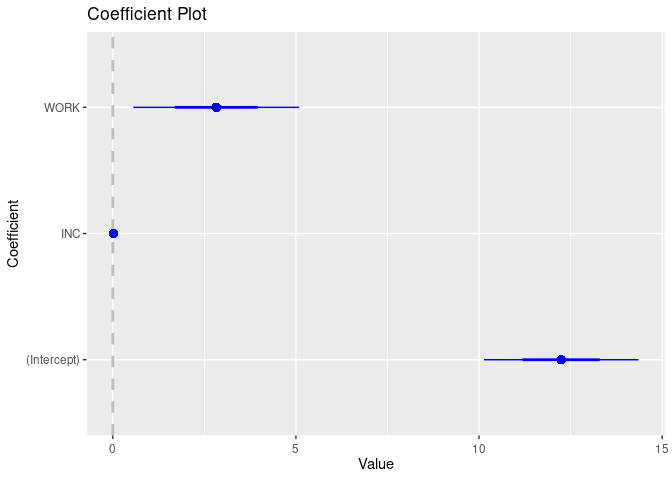

In [ ]:
p_load(coefplot)

### 結果の図示2

定数項は基準が違うために一緒にプロットすると見づらい場合がある.
`intercept = FALSE`を引数に入れれば定数項を表示しない.

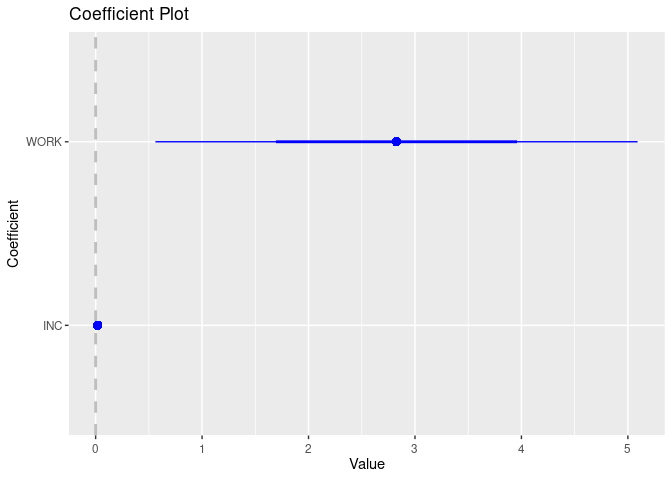

In [ ]:
coefplot(model2,
         intercept = FALSE)

### 複数のモデルを比較

複数のモデルをグラフを用いて比較するには,
`coefplot`パッケージの`multiplot()`関数が便利.

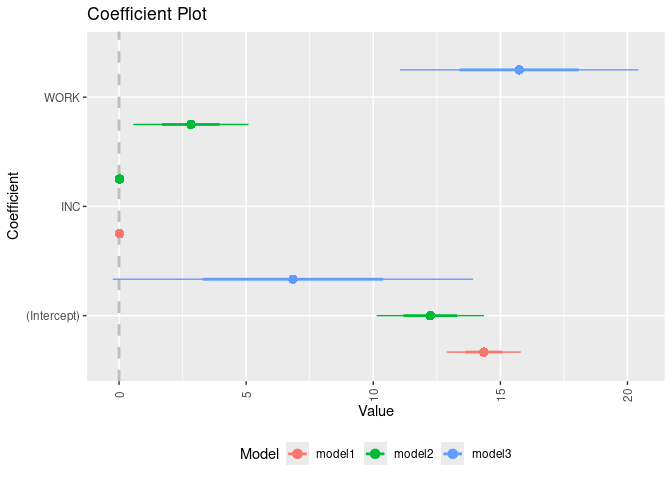

In [ ]:
multiplot(model1, 
          model2, 
          model3)

### 標準回帰係数のプロット

標準回帰係数へは`arm`パッケージの`standardize(standardize.y = TRUE)`で変換できる.

Installing package into '/cloud/lib/x86_64-pc-linux-gnu-library/4.4'
(as 'lib' is unspecified)

also installing the dependencies 'minqa', 'nloptr', 'RcppEigen', 'lme4', 'abind'


arm installed

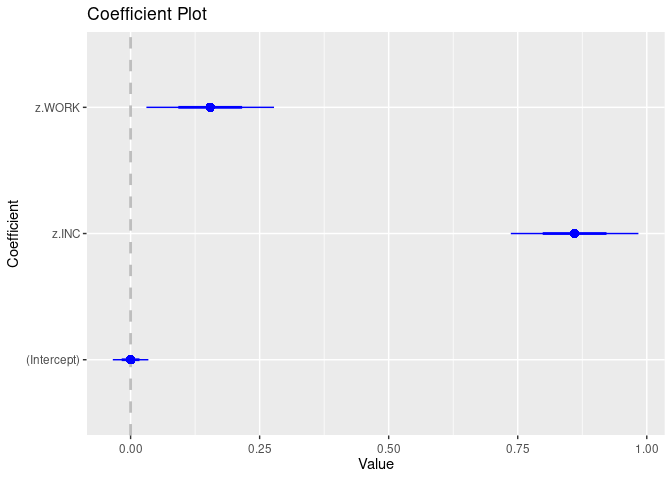

In [ ]:
p_load(arm)

### 標準回帰係数のマルチプロット

標準回帰係数へは`arm`パッケージの`standardize(standardize.y = TRUE)`で変換すれば,
マルチプロットもできる.

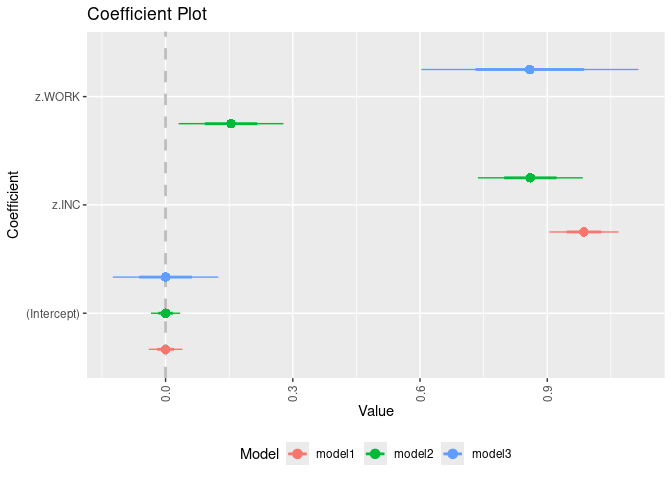

In [ ]:
multiplot(
  arm::standardize(model1,
                   standardize.y = TRUE),
  arm::standardize(model2,
                   standardize.y = TRUE),
  arm::standardize(model3,
                   standardize.y = TRUE),
  names = c("model1", "model2", "model3")
  )

### 予測値の算出

`predict()`関数を利用して予測値を算出する.

In [ ]:
p_load(dplyr)
pred1 <- predict(model1)
pred2 <- predict(model2)
pred3 <- predict(model3)

### 予測値と実測値のプロット

予測値と実測値のプロットを行う.

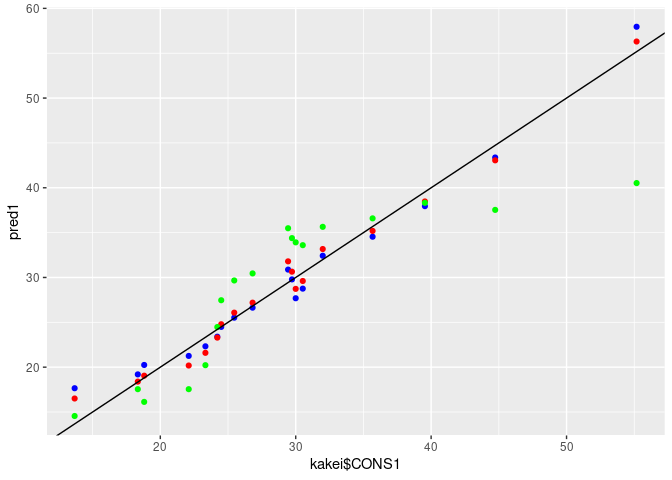

In [ ]:
p_load(ggplot2)
ggplot() +
  aes(x = kakei$CONS1) +
  geom_point(aes(y = pred1),
             colour = "blue") +
  geom_point(aes(y = pred2),
             colour = "red") +
  geom_point(aes(y = pred3),
             colour = "green") +
  geom_abline(slope     = 1, 
              intercept = 0)

### 分散不均一の考慮

Welchのt検定のように分散不均一を考慮する際には`estimatr`パッケージの`lm_robust()`関数を利用すると分散不均一を補正した標準誤差を計算できる.

In [ ]:
p_load(estimatr)

Installing package into '/cloud/lib/x86_64-pc-linux-gnu-library/4.4'
(as 'lib' is unspecified)

also installing the dependency 'Formula'


estimatr installed


Call:
lm_robust(formula = CONS1 ~ INC + WORK, data = kakei, se_type = "HC3")

Standard error type:  HC3 

Coefficients:
            Estimate Std. Error t value  Pr(>|t|) CI Lower CI Upper DF
(Intercept) 12.24162   1.592422   7.687 1.402e-06   8.8475 15.63579 15
INC          0.01869   0.003559   5.251 9.781e-05   0.0111  0.02628 15
WORK         2.82637   2.140924   1.320 2.066e-01  -1.7369  7.38964 15

Multiple R-squared:  0.9812 ,   Adjusted R-squared:  0.9786 
F-statistic:   101 on 2 and 15 DF,  p-value: 1.981e-09

分散不均一を補正した結果は`summ()`関数の中で`robust`の引数を指定することでも表示できる.

In [ ]:
summ(model2, robust = "HC3")

MODEL INFO:
Observations: 18
Dependent Variable: CONS1
Type: Linear regression 

MODEL FIT:
χ²(2) = 1661.80, p = 0.00
Pseudo-R² (Cragg-Uhler) = 0.98
Pseudo-R² (McFadden) = 0.54
AIC = 69.39, BIC = 72.95 

Standard errors: Robust, type = HC3
------------------------------------------------
                     Est.   S.E.   t val.      p
----------------- ------- ------ -------- ------
(Intercept)         12.24   1.59     7.69   0.00
INC                  0.02   0.00     5.25   0.00
WORK                 2.83   2.14     1.32   0.19
------------------------------------------------

Estimated dispersion parameter = 2.13 

### LOOCVの計算

`caret`パッケージを利用してLOOCVを求める.

In [ ]:
p_load(caret)

Installing package into '/cloud/lib/x86_64-pc-linux-gnu-library/4.4'
(as 'lib' is unspecified)

also installing the dependencies 'shape', 'future.apply', 'numDeriv', 'progressr', 'SQUAREM', 'diagram', 'lava', 'prodlim', 'timechange', 'proxy', 'iterators', 'clock', 'gower', 'hardhat', 'ipred', 'lubridate', 'timeDate', 'e1071', 'foreach', 'ModelMetrics', 'pROC', 'recipes'


caret installed

Linear Regression 

18 samples
 1 predictor

No pre-processing
Resampling: Leave-One-Out Cross-Validation 
Summary of sample sizes: 17, 17, 17, 17, 17, 17, ... 
Resampling results:

  RMSE      Rsquared   MAE     
  2.195815  0.9533844  1.537678

Tuning parameter 'intercept' was held constant at a value of TRUE

In [ ]:
LOOCV2 <- train(CONS1 ~ INC + WORK, 
                data      = kakei,
                method    = "lm", 
                trControl = trainControl(method = "LOOCV"))
LOOCV2

Linear Regression 

18 samples
 2 predictor

No pre-processing
Resampling: Leave-One-Out Cross-Validation 
Summary of sample sizes: 17, 17, 17, 17, 17, 17, ... 
Resampling results:

  RMSE      Rsquared   MAE     
  1.930452  0.9648556  1.495215

Tuning parameter 'intercept' was held constant at a value of TRUE

In [ ]:
LOOCV3 <- train(CONS1 ~ WORK, 
                data      = kakei,
                method    = "lm", 
                trControl = trainControl(method = "LOOCV"))
LOOCV3

Linear Regression 

18 samples
 1 predictor

No pre-processing
Resampling: Leave-One-Out Cross-Validation 
Summary of sample sizes: 17, 17, 17, 17, 17, 17, ... 
Resampling results:

  RMSE     Rsquared   MAE     
  5.71096  0.6558332  4.293896

Tuning parameter 'intercept' was held constant at a value of TRUE

### 残差と予測値のプロット

残差プロットをするためには,
`ggfortify`パッケージと`autoplot()`関数を利用するのが便利. x軸が予測値,
y軸が残差

Installing package into '/cloud/lib/x86_64-pc-linux-gnu-library/4.4'
(as 'lib' is unspecified)

also installing the dependency 'gridExtra'


ggfortify installed

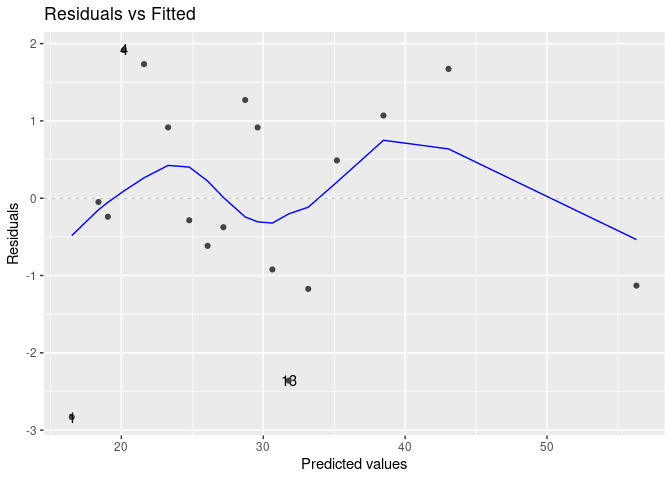

In [ ]:
p_load(ggfortify)

### 残差の平方根プロット

残差の変動を確認するため, x軸が予測値,
y軸が標準化した残差の絶対値の平和根の散布図を描く.

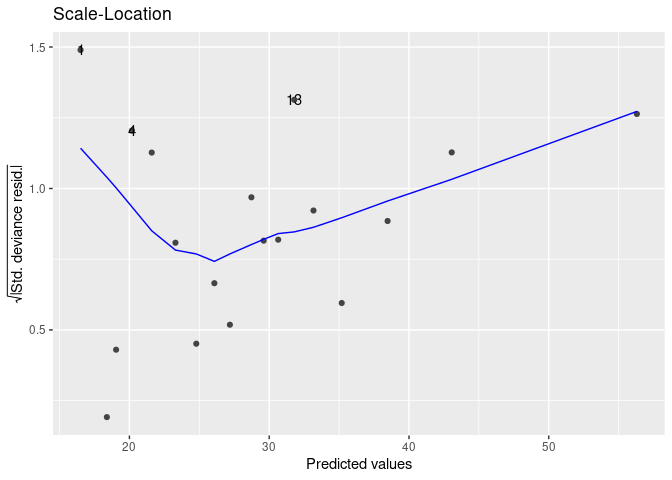

In [ ]:
autoplot(model2, 
         which = 3, 
         ncol  = 1)

### 残差の正規Q-Qプロット

残差の正規Q-Qプロットで直線状に標準化した残差が乗っているかチェックする.

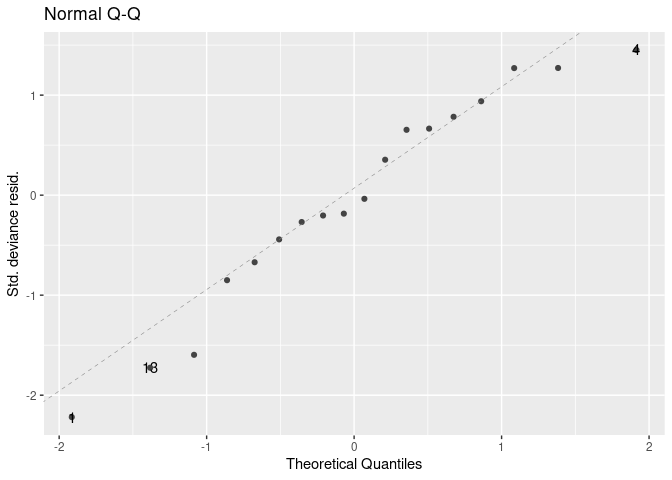

In [ ]:
autoplot(model2, 
         which = 2,
         ncol  = 1)

### 標準化残差とてこ比のプロット

x軸にてこ比, y軸に標準化残差を描画する.

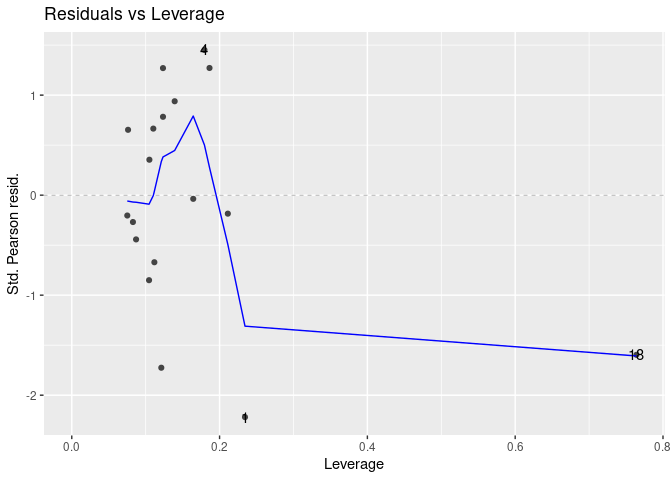

In [ ]:
autoplot(model2,
         which = 5,
         ncol  = 1)

### てこ比とCookの距離のプロット

x軸にてこ比, y軸にCookの距離を設定し, 散布図を描く.

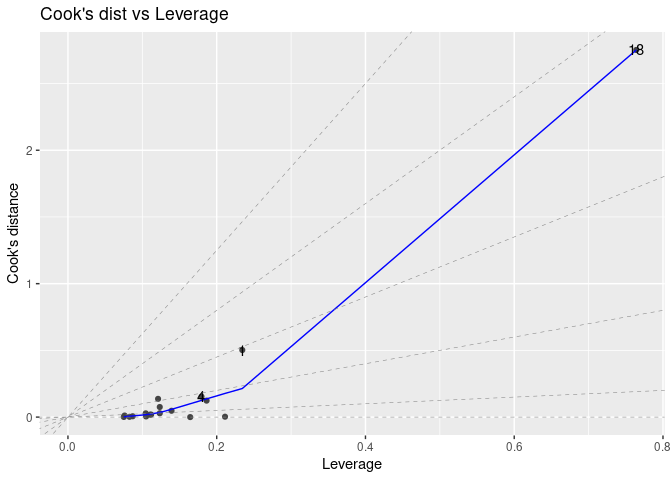

In [ ]:
autoplot(model2, 
         which = 6, 
         ncol  = 1)

### 多重共線性のチェック

多重共線性のチェックのため, VIFを計算する. VIFの計算には,
`summ()`関数の引数で`vifs = TRUE`を追加する.
VIFが10以下であれば問題ない. 2以下が理想だとする意見もある.

In [ ]:
summ(model2, vifs = TRUE)

MODEL INFO:
Observations: 18
Dependent Variable: CONS1
Type: Linear regression 

MODEL FIT:
χ²(2) = 1661.80, p = 0.00
Pseudo-R² (Cragg-Uhler) = 0.98
Pseudo-R² (McFadden) = 0.54
AIC = 69.39, BIC = 72.95 

Standard errors:MLE
-------------------------------------------------------
                     Est.   S.E.   t val.      p    VIF
----------------- ------- ------ -------- ------ ------
(Intercept)         12.24   1.05    11.60   0.00       
INC                  0.02   0.00    13.92   0.00   3.04
WORK                 2.83   1.13     2.50   0.02   3.04
-------------------------------------------------------

Estimated dispersion parameter = 2.13 